# 1. Set environment, import all necessary libraries 

In [45]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, chi2_contingency, ttest_ind
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# 2. Data Ingestion
## 2.1 Import data into Python Pandas DataFrame

In [2]:
df = pd.read_csv('../data/bank.csv', sep=';')
print(df.dtypes)
df

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


# 3. Explorative Data Analysis
## 3.1  - check missing and duplicated values 
### 3.1.1 No missing and duplicated values

In [3]:
print("\n", "Missing Value: " + str(df.isnull().values.any()), '\n', "Duplicated Rows: " + str(df.duplicated().any()))


 Missing Value: False 
 Duplicated Rows: False


## 3.2 Deal with numeric and categorical features separately
### 3.2.1 Take out numeric features

In [4]:
X_num = df.drop(columns=['y']).select_dtypes(include=np.number)
X_num

,age,balance,day,duration,campaign,pdays,previous
0,30,1787,19,79,1,-1,0
1,33,4789,11,220,1,339,4
2,35,1350,16,185,1,330,1
3,30,1476,3,199,4,-1,0
4,59,0,5,226,1,-1,0
...,...,...,...,...,...,...,...
4516,33,-333,30,329,5,-1,0
4517,57,-3313,9,153,1,-1,0
4518,57,295,19,151,11,-1,0
4519,28,1137,6,129,4,211,3


### 3.2.2 Take out categorical features

In [5]:
X_obj = df.drop(columns=['y']+list(X_num.columns))
X_obj

,job,marital,education,default,housing,loan,contact,month,poutcome
0,unemployed,married,primary,no,no,no,cellular,oct,unknown
1,services,married,secondary,no,yes,yes,cellular,may,failure
2,management,single,tertiary,no,yes,no,cellular,apr,failure
3,management,married,tertiary,no,yes,yes,unknown,jun,unknown
4,blue-collar,married,secondary,no,yes,no,unknown,may,unknown
...,...,...,...,...,...,...,...,...,...
4516,services,married,secondary,no,yes,no,cellular,jul,unknown
4517,self-employed,married,tertiary,yes,yes,yes,unknown,may,unknown
4518,technician,married,secondary,no,no,no,cellular,aug,unknown
4519,blue-collar,married,secondary,no,no,no,cellular,feb,other


## 3.3 Check data distributions
### 3.3.1 Check the distribution of the response variable by its value counts in barplot
#### The "yes" to "no" ratio is roughly 1:8, which will be handled in the later classification processing

no     4000
yes     521
Name: y, dtype: int64


<AxesSubplot:>

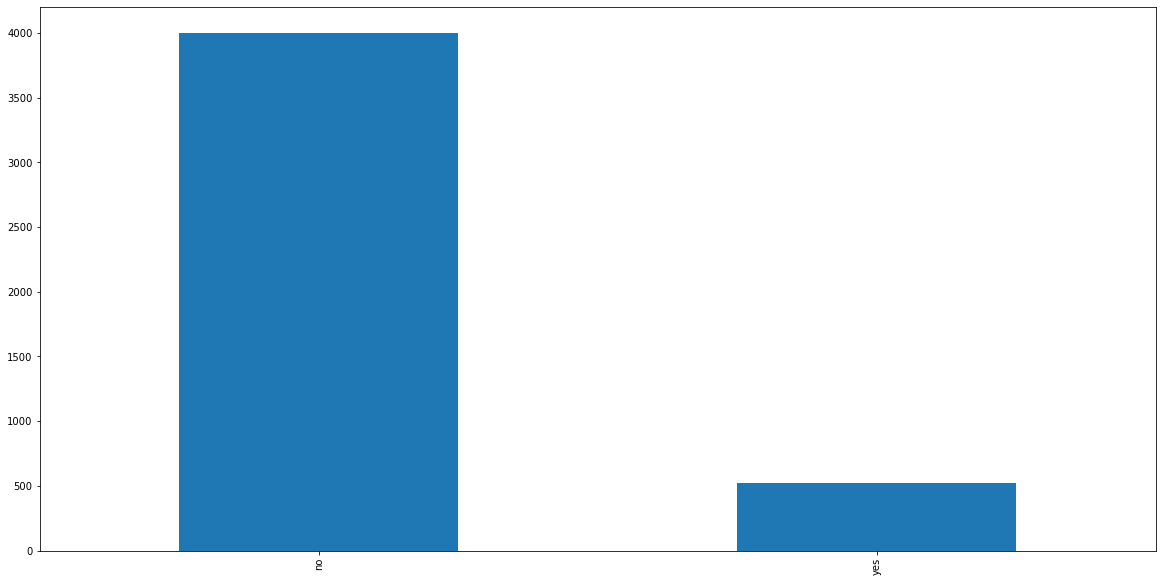

In [6]:
print(df.y.value_counts())
plt.figure(figsize=(20, 10))
df.y.value_counts().plot(kind='bar')

### 3.3.2 Check the distributions of numeric features by histograms

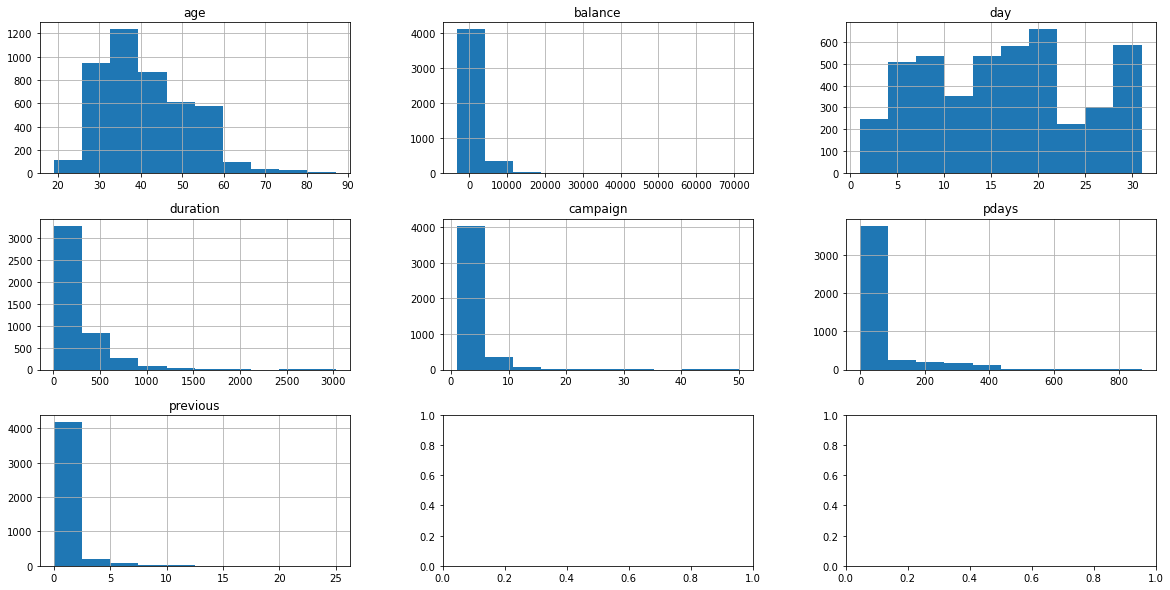

In [7]:
columns = X_num.columns
fig, axs = plt.subplots(3, 3, figsize=(20, 10)) #necessary line
for ax, col in zip(axs.flatten(), columns):
    X_num.hist(column=col, ax=ax)

In [8]:
# X_num_log = pd.DataFrame(columns=X_num.columns)
# for fea in X_num.columns:
#     X_num_log[fea] = np.log2(X_num[fea]+(-X_num[fea].min())+1e-100)
# X_num_log

### 3.3.3 Check the distribuions of Categorical features by value counts in barplots

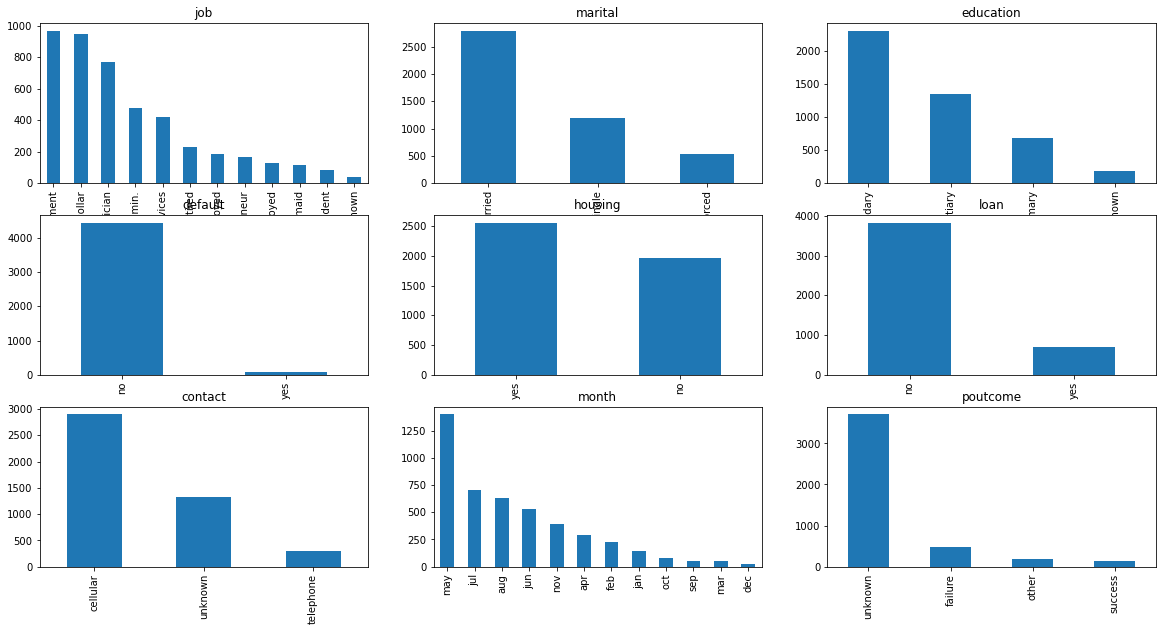

In [9]:
columns = X_obj.columns
fig, axs = plt.subplots(3, 3, figsize=(20, 10)) 
for ax, col in zip(axs.flatten(), columns):
    X_obj[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(col)

# 4. Filtering Feature Selection
## 4.1 Filtering Feature Selection on numeric features by 2-sample t-tests
For every individual numeric feature, make a t-test between the two separate groups, one group contains values with the label y = "yes", and the other group contains values with the label y = "no"

In [10]:
pvals = []
for fea in X_num.columns:
    t_sts, p = ttest_ind(df[df['y']=='yes'][fea], df[df['y']=='no'][fea])
    pvals.append(p)
sig_num = pd.DataFrame(zip(X_num.columns, pvals), columns=['Feature', 'p-Value']).sort_values(by='p-Value')
sig_num

,Feature,p-Value
3,duration,2.150445e-174
6,previous,3.477971e-15
5,pdays,2.287071e-12
4,campaign,3.885794e-05
0,age,2.424536e-03
1,balance,2.287158e-01
2,day,4.497348e-01


## 4.2 Filtering Feature Selection on categorical features by Chi-square tests
For every individual categorical feature, make a Chi-square test by its cross-table with the label y

In [11]:
pvals2 = []
for fea in X_obj.columns:
    chi2, p, dof, ex = chi2_contingency(pd.crosstab(df.y, df[fea]))
    pvals2.append(p)
sig_obj = pd.DataFrame(zip(X_obj.columns, pvals2), columns=['Feature', 'p-Value']).sort_values(by='p-Value')
sig_obj

,Feature,p-Value
8,poutcome,1.539883e-83
7,month,2.195355e-47
6,contact,8.304301e-20
4,housing,2.714700e-12
0,job,1.901391e-10
5,loan,2.914829e-06
1,marital,7.373535e-05
2,education,1.625240e-03
3,default,1.000000e+00


## 4.3 Filter in the significant numeric and categorical features
Set alpha level to be 0.05 and use Bonferroni method to adjust multiple tests

In [12]:
alpha_level = 0.05
num_col_num = sig_num.shape[0]
num_col_obj = sig_obj.shape[0]
sig_num_col = list(sig_num[sig_num['p-Value']<(alpha_level/sig_num.shape[0])]['Feature'])
sig_obj_col = list(sig_obj[sig_obj['p-Value']<(alpha_level/sig_obj.shape[0])]['Feature'])
print(len(sig_num_col), len(sig_obj_col))

5 8


# 5. Feature Engineering
## 5.1 Map "yes"/"no" to 1/0 for binary variables
Binay variables will be converted to 1/0 to aviod redendancy, since if use one-hot enconding, the two new features will be perfectly correlated

In [13]:
df_sig = df[sig_num_col+sig_obj_col+['y']]
df_sig = df_sig.replace({'housing': {'yes': 1, 'no': 0}})
df_sig = df_sig.replace({'loan': {'yes': 1, 'no': 0}})
df_sig = df_sig.replace({'y': {'yes': 1, 'no': 0}})
print(df_sig.shape)

(4521, 14)


## 5.2 Convert categorical variable to numerical by one-hot encoding

In [14]:
df_sig = pd.get_dummies(df_sig)
print(df_sig.shape)
df_sig

(4521, 46)


,duration,previous,pdays,campaign,age,housing,loan,y,poutcome_failure,poutcome_other,...,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown
0,79,0,-1,1,30,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
1,220,4,339,1,33,1,1,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,185,1,330,1,35,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
3,199,0,-1,4,30,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,226,0,-1,1,59,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,329,0,-1,5,33,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4517,153,0,-1,1,57,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4518,151,0,-1,11,57,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
4519,129,3,211,4,28,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


# 6. Classification Modeling
## 6.1 Prpare training and testing data by random splitting
80% data for training; 20% data for testing

In [15]:
X = df_sig.drop(columns=['y'])
y = df_sig['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888)

## 6.2 Use SMOTE to resample the TRAIN DATA ONLY
### Leave the test data AS-IS to best represent the "Reality"

(3616, 45)
(6382, 45)


<AxesSubplot:>

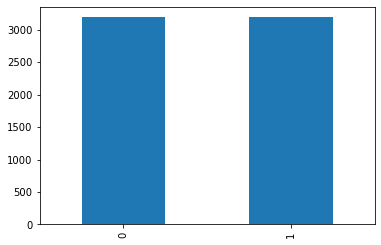

In [16]:
print(X_train.shape)
sm = SMOTE(random_state=888)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(X_train.shape)
y_train.value_counts().plot(kind='bar')

## 6.3 Define multiple classification algorithms
### Including Random Forest, LASSO, Support Vector Machine, k-Nearst Neighbor. 
### All chosen algorithms have the "class_weight" parameter to address the imbalance of label y.
#### Set the "class_weight" parameter to be "balanced" will bring the imbalanced training data into balanced situation. 
Put the defined algorithms and their names into 2 corresponding lists

In [17]:
rf = RandomForestClassifier(max_depth=5, random_state=888, class_weight= 'balanced')
lasso = LogisticRegression(solver = 'liblinear', penalty='l1', class_weight = 'balanced', random_state=888)
svc = SVC(class_weight='balanced', C=2, random_state=888)
knn = KNeighborsClassifier(n_neighbors=10)
elasticnet = SGDClassifier(loss='hinge', penalty='elasticnet', l1_ratio=0.6,  random_state=888, class_weight='balanced')
classifiers = [rf, lasso, svc, knn, elasticnet]
classifier_names = ['Random Forest', 'LASSO', 'Support Vector Machine', 'k-Nearest Neighbor', 'ElasticNet']

## 6.4 Make a function to perform training, testing and evaluation
### It displays confusion matrix, and returns the f1-score, precision, recall, accuracy as well as the trained classifier itself.

In [18]:
def train_test_evaluate(clf, clf_name, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    f1 = metrics.f1_score(y_test, pred, average = 'macro')
    pre = metrics.precision_score(y_test, pred, average='macro')
    rec = metrics.recall_score(y_test, pred, average = 'macro')
    acc = metrics.accuracy_score(y_test, pred)
    print("The Test Result for Classifier: " + clf_name)
    print(metrics.classification_report(y_test, pred, target_names=['no', 'yes']))
    cm = metrics.confusion_matrix(y_test, pred)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return(f1, pre, rec, acc, clf)

## 6.5 Make function to scan all defined classification algorithm
### For each algorithm, train a classifier on training data and test/evaluate it by the test data
### Returen all trained classifier and their evaluation results

In [19]:
def compare_classifers(X_train, y_train, X_test, y_test, clfs, clf_names):
    f1scores = []
    precisions = []
    recalls = []
    accuracies = []
    fitted_clfs = []
    for i in range(len(clfs)):
        f1, pre, rec, acc, fitted_clf = train_test_evaluate(clfs[i], clf_names[i], X_train, y_train, X_test, y_test)
        f1scores.append(f1)
        precisions.append(pre)
        recalls.append(rec)
        accuracies.append(acc)
        fitted_clfs.append(fitted_clf)
    df_evl = pd.DataFrame(zip(clf_names, accuracies, precisions, recalls,f1scores), 
                          columns = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1Score']).sort_values(by='F1Score', ascending=False)
    return(df_evl, fitted_clfs)

### 6.5.1 Run the function to loop all defined algorithms to check performance 

The Test Result for Classifier: Random Forest
              precision    recall  f1-score   support

          no       0.94      0.88      0.91       809
         yes       0.34      0.54      0.42        96

    accuracy                           0.84       905
   macro avg       0.64      0.71      0.66       905
weighted avg       0.88      0.84      0.86       905



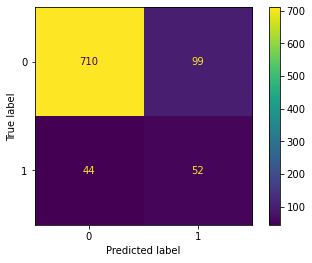

The Test Result for Classifier: LASSO
              precision    recall  f1-score   support

          no       0.93      0.97      0.95       809
         yes       0.63      0.39      0.48        96

    accuracy                           0.91       905
   macro avg       0.78      0.68      0.71       905
weighted avg       0.90      0.91      0.90       905



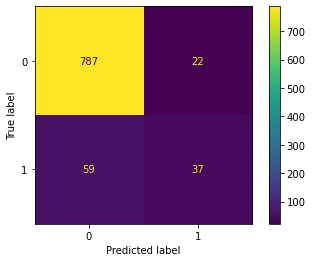

The Test Result for Classifier: Support Vector Machine
              precision    recall  f1-score   support

          no       0.98      0.78      0.87       809
         yes       0.32      0.84      0.46        96

    accuracy                           0.79       905
   macro avg       0.65      0.81      0.67       905
weighted avg       0.91      0.79      0.83       905



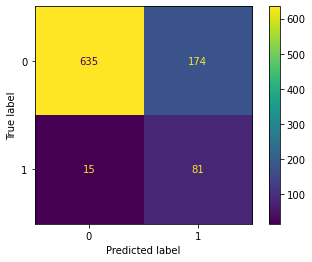

The Test Result for Classifier: k-Nearest Neighbor
              precision    recall  f1-score   support

          no       0.96      0.80      0.87       809
         yes       0.30      0.71      0.42        96

    accuracy                           0.79       905
   macro avg       0.63      0.75      0.64       905
weighted avg       0.89      0.79      0.82       905



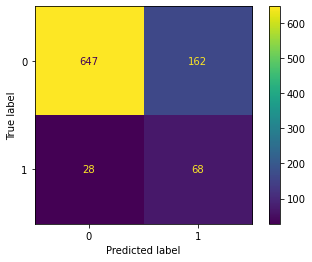

The Test Result for Classifier: ElasticNet
              precision    recall  f1-score   support

          no       0.95      0.91      0.93       809
         yes       0.45      0.61      0.52        96

    accuracy                           0.88       905
   macro avg       0.70      0.76      0.73       905
weighted avg       0.90      0.88      0.89       905



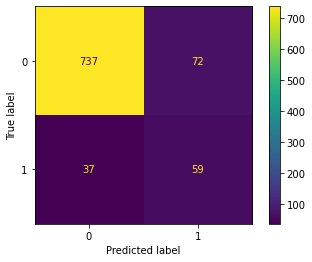

In [20]:
df_compare_res, fitted_clfs = compare_classifers(X_train, y_train, X_test, y_test, classifiers, classifier_names)

### 6.5.2 Display the aggregated evaluation result of all classifiers
#### Based on the F-1 score, ElasticNet, with which L1 Ratio set to 0.6, has the best performance

In [21]:
df_compare_res

,Classifier,Accuracy,Precision,Recall,F1Score
4,ElasticNet,0.879558,0.701289,0.762792,0.725484
1,LASSO,0.910497,0.778689,0.679111,0.714238
2,Support Vector Machine,0.791160,0.647285,0.814335,0.665999
0,Random Forest,0.841989,0.643008,0.709647,0.664781
3,k-Nearest Neighbor,0.790055,0.627085,0.754043,0.644573


# 6.6 Feature importance analysis
## 6.6.1 Feature importance analysis for LASSO
### 6.6.1.1 Use coefficients to indicate the importance of corresponding features

In [22]:
df_elasticnet_fea_imp = pd.DataFrame(zip(X_train.columns, fitted_clfs[4].coef_[0]), 
                             columns=['feature', 'coefficient']).sort_values(by='coefficient', ascending=False)
df_elasticnet_fea_imp

,feature,coefficient
9,poutcome_success,143.094604
1,previous,31.737515
4,age,27.462217
18,month_mar,14.307727
0,duration,4.822718
2,pdays,3.539626
23,contact_cellular,2.253872
22,month_sep,0.000000
13,month_dec,-8.540522
21,month_oct,-10.121842


#### 6.6.1.2 Plot all features by their coefficients

<AxesSubplot:xlabel='feature'>

<Figure size 1440x720 with 0 Axes>

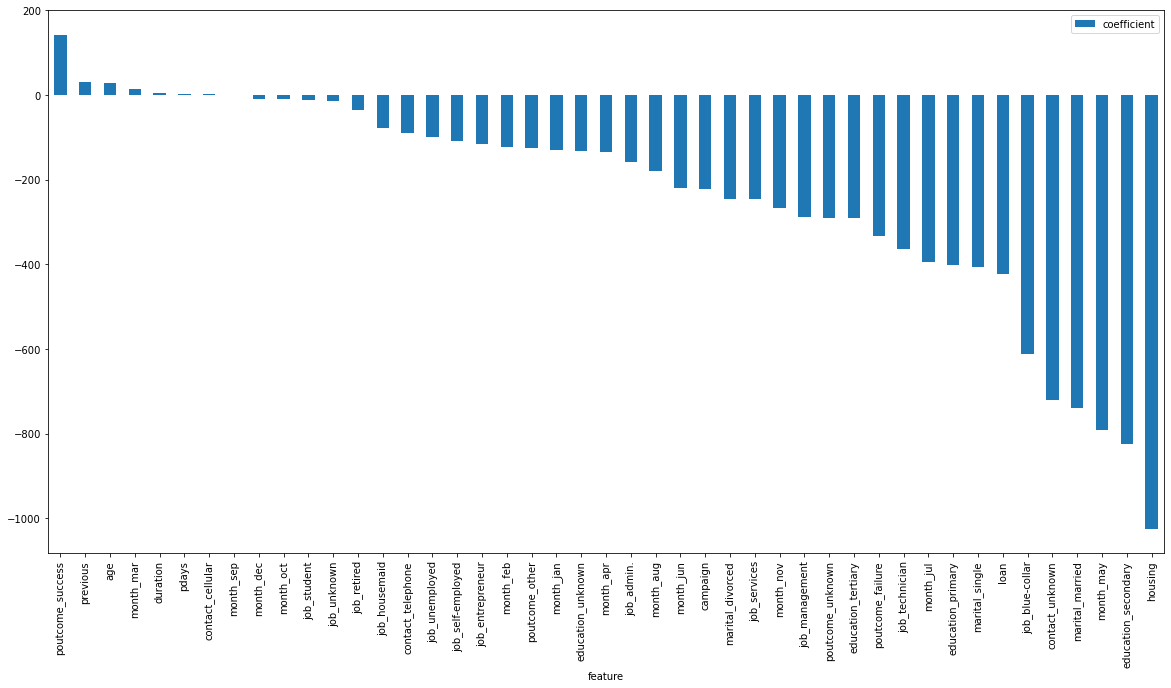

In [23]:
plt.figure(figsize=(20,10))
df_elasticnet_fea_imp.plot.bar(x='feature', y='coefficient', rot=90, figsize=(20, 10))

#### 6.6.1.3 Pick up features with |coefficients| >100 

In [24]:
df_elasticnet_fea_imp_1 = df_elasticnet_fea_imp[(df_elasticnet_fea_imp.coefficient>100)|(df_elasticnet_fea_imp.coefficient<-100)]
df_elasticnet_fea_imp_1

,feature,coefficient
9,poutcome_success,143.094604
32,job_self-employed,-107.359792
28,job_entrepreneur,-114.641035
14,month_feb,-122.460917
8,poutcome_other,-124.025780
15,month_jan,-130.594623
44,education_unknown,-132.186477
11,month_apr,-134.578626
26,job_admin.,-158.395140
12,month_aug,-178.210062


#### 6.6.1.4.Plot features with |coefficients| >100

<AxesSubplot:xlabel='feature'>

<Figure size 1440x720 with 0 Axes>

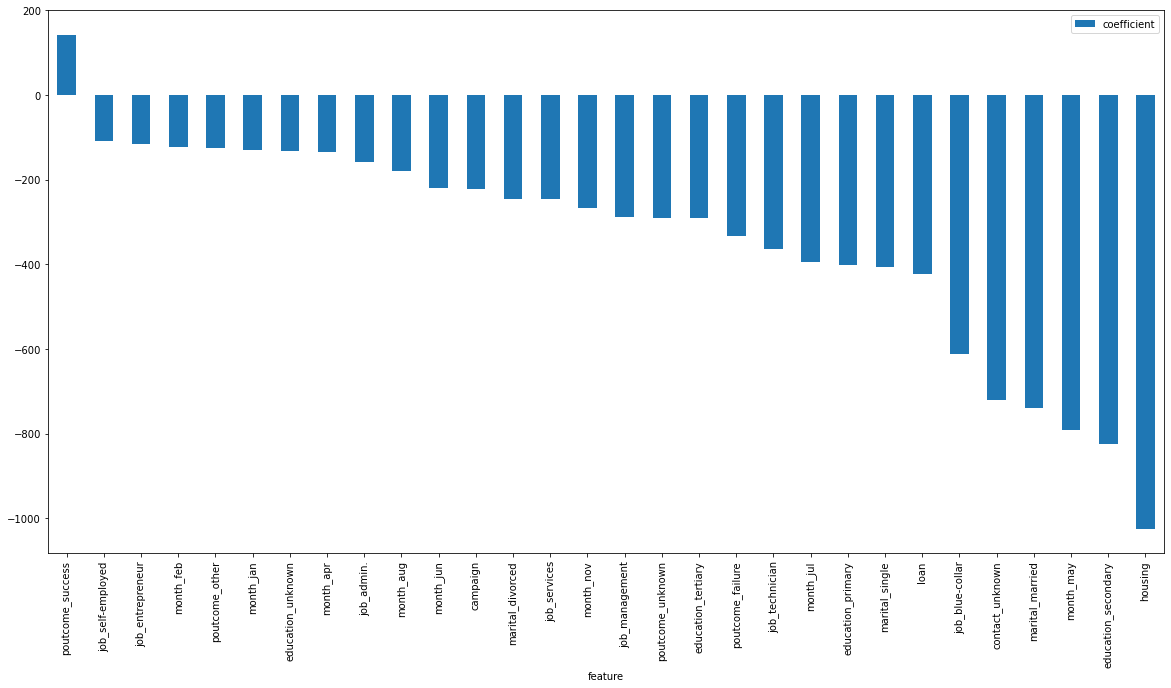

In [25]:
plt.figure(figsize=(20,10))
df_elasticnet_fea_imp_1.plot.bar(x='feature', y='coefficient', rot=90, figsize=(20, 10))

### 6.6.2 Analyze feature importance for the Random Forest classifier

In [26]:
df_rf_fea_imp = pd.DataFrame(zip(X_train.columns, fitted_clfs[0].feature_importances_), 
                             columns=['feature', 'importance']).sort_values(by='importance', ascending=False)

In [27]:
df_rf_fea_imp

,feature,importance
0,duration,0.276097
25,contact_unknown,0.101212
5,housing,0.091892
19,month_may,0.061563
42,education_secondary,0.051272
27,job_blue-collar,0.051107
39,marital_married,0.049367
6,loan,0.038217
41,education_primary,0.027755
16,month_jul,0.026441


<AxesSubplot:xlabel='feature'>

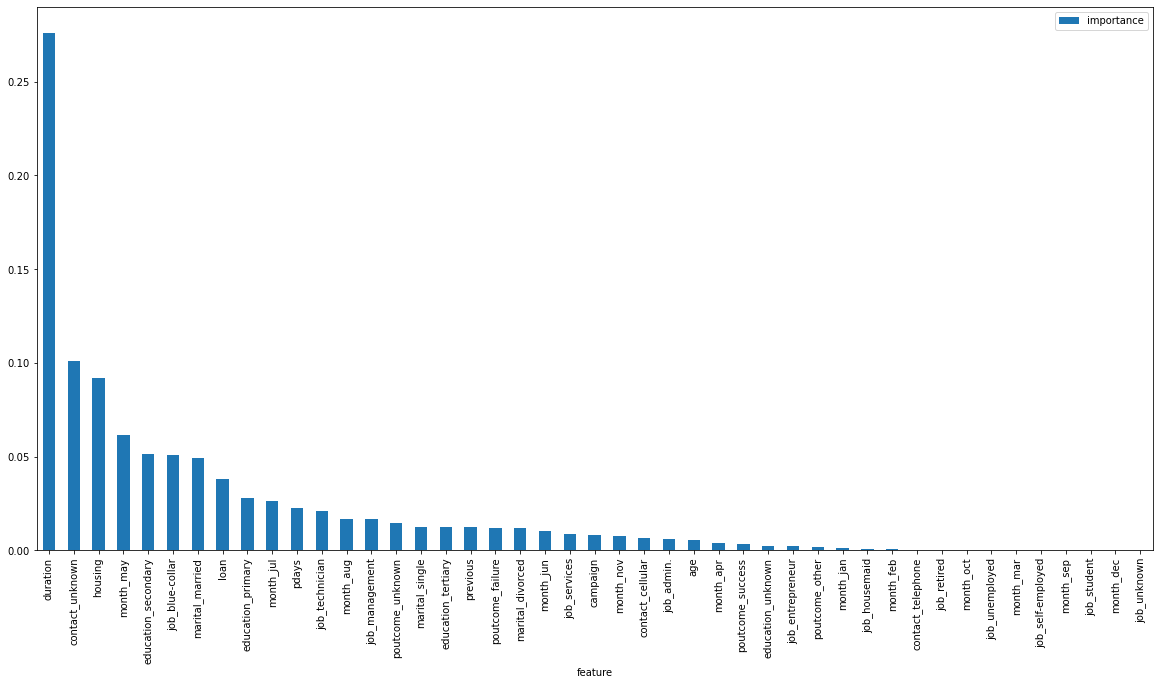

In [28]:
df_rf_fea_imp.plot.bar(x='feature', y='importance', rot=90, figsize=(20, 10))

In [29]:
df_rf_fea_imp_1 = df_rf_fea_imp[df_rf_fea_imp.importance>0.1]
df_rf_fea_imp_1

,feature,importance
0,duration,0.276097
25,contact_unknown,0.101212


<AxesSubplot:xlabel='feature'>

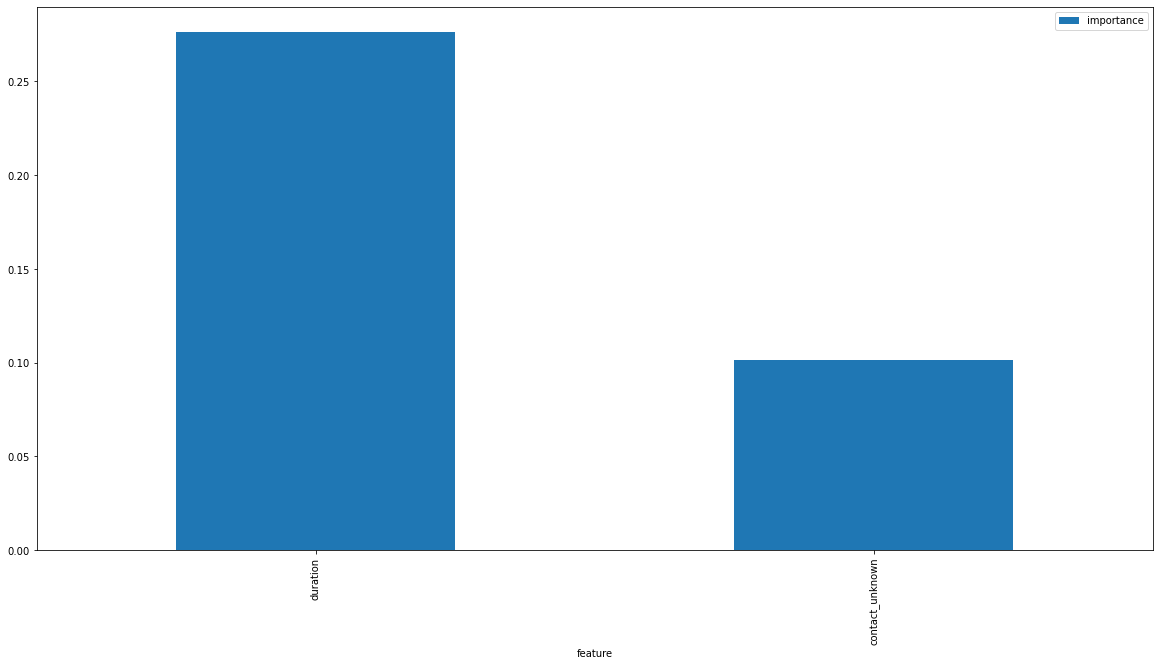

In [30]:
df_rf_fea_imp_1.plot.bar(x='feature', y='importance', rot=90, figsize=(20, 10))

# 7. Conclusion
## 7.1. The ElasticNet is the best model based on the training/testing and evaluation by F-1 Score
## 7.2. The "housing" feature is the most importance feature in ElasticNet classifier
## 7.3. The "duration" feature is the most importance feature in Random Forest classifier

# ======== The main analysis/modeling has finished, thank you! ========

# 8. Additional Tries
## 8.1 Additional Try No. 1: Try Recursive Feature Elimination (RFE)
### Slightly improved LASSO, but NO improvement on Random Forest

In [31]:
from sklearn.feature_selection import RFECV

### 8.1.1 Use the Random Forest classifier to do RFE feature selection
#### Didnot use ElasticNet because it is an embedded feature selection which will be redundant

In [32]:
rfe_cv = RFECV(rf, step=1, cv=5, min_features_to_select=1)
rfe_cv.fit(X_train, y_train)
print(rfe_cv.support_)
rfe_cv.ranking_
rfe_res = pd.DataFrame(zip(X_train.columns, rfe_cv.support_),columns=['feature', 'selected'])
selected_col = rfe_res[rfe_res.selected==True].feature
X_train_selected = X_train[selected_col]
X_test_selected = X_test[selected_col]

[ True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True False  True  True False False  True
  True  True  True  True  True False  True False False  True False  True
 False False  True  True  True  True  True  True  True]


In [33]:
rfe_res[rfe_res['selected']==True]

,feature,selected
0,duration,True
1,previous,True
2,pdays,True
3,campaign,True
4,age,True
5,housing,True
6,loan,True
7,poutcome_failure,True
8,poutcome_other,True
9,poutcome_success,True


The Test Result for Classifier: Random Forest
              precision    recall  f1-score   support

          no       0.94      0.87      0.91       809
         yes       0.34      0.56      0.43        96

    accuracy                           0.84       905
   macro avg       0.64      0.72      0.67       905
weighted avg       0.88      0.84      0.86       905



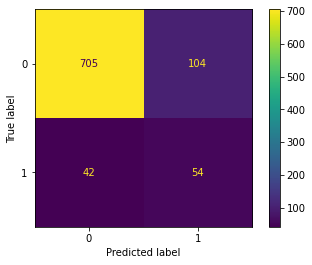

The Test Result for Classifier: LASSO
              precision    recall  f1-score   support

          no       0.94      0.96      0.95       809
         yes       0.56      0.47      0.51        96

    accuracy                           0.90       905
   macro avg       0.75      0.71      0.73       905
weighted avg       0.90      0.90      0.90       905



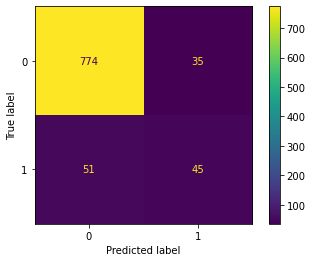

The Test Result for Classifier: Support Vector Machine
              precision    recall  f1-score   support

          no       0.98      0.78      0.87       809
         yes       0.32      0.84      0.46        96

    accuracy                           0.79       905
   macro avg       0.65      0.81      0.67       905
weighted avg       0.91      0.79      0.83       905



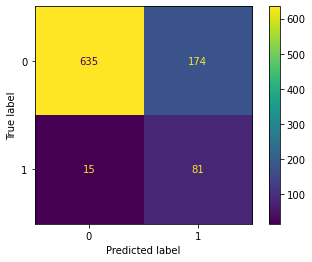

The Test Result for Classifier: k-Nearest Neighbor
              precision    recall  f1-score   support

          no       0.96      0.80      0.87       809
         yes       0.30      0.71      0.42        96

    accuracy                           0.79       905
   macro avg       0.63      0.76      0.65       905
weighted avg       0.89      0.79      0.83       905



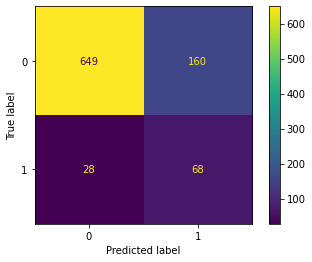

The Test Result for Classifier: ElasticNet
              precision    recall  f1-score   support

          no       0.98      0.78      0.87       809
         yes       0.32      0.86      0.46        96

    accuracy                           0.79       905
   macro avg       0.65      0.82      0.66       905
weighted avg       0.91      0.79      0.82       905



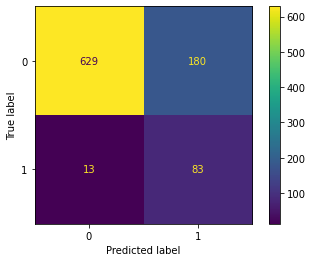

In [34]:
df_compare_rfe_res = compare_classifers(X_train_selected, y_train, X_test_selected, y_test, classifiers, classifier_names)

### 8.1.2 The best peformed classifier is a little bit better than what before RFE
#### Decided to keep using ElasticNet as the final model

In [35]:
df_compare_rfe_res[0]

,Classifier,Accuracy,Precision,Recall,F1Score
1,LASSO,0.904972,0.750341,0.712743,0.729366
2,Support Vector Machine,0.791160,0.647285,0.814335,0.665999
0,Random Forest,0.838674,0.642774,0.716973,0.665683
4,ElasticNet,0.786740,0.647670,0.821043,0.664692
3,k-Nearest Neighbor,0.792265,0.628443,0.755279,0.646619


### 8.1.3 The feature importance (coefficient) on the LASSO model after RFE

In [36]:
df_rfe_lasso_fea_imp = pd.DataFrame(zip(X_train.columns, df_compare_rfe_res[1][1].coef_[0]), 
                             columns=['feature', 'coefficient']).sort_values(by='coefficient', ascending=False)
df_rfe_lasso_fea_imp

,feature,coefficient
0,duration,0.004384
2,pdays,0.002382
9,poutcome_success,0.000000
1,previous,-0.003139
4,age,-0.004829
3,campaign,-0.094809
5,housing,-0.479395
25,contact_unknown,-0.614382
22,month_sep,-0.796289
6,loan,-0.844441


## 8.2 Additional Try No. 2: Try AutoML using H2O
### NO Improvement according to the F-1 Score

In [37]:
import h2o
from h2o.automl import H2OAutoML

In [38]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 days 0 hours 52 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_james_ghviv1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.675 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [39]:
df_h2o = df_sig.copy()
df_h2o = df_h2o.replace({'y': {1:'yes', 0:'no'}})
hf = h2o.H2OFrame(df_h2o)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [40]:
X_h2o = hf.columns
y_h2o = "y"
X_h2o.remove(y_h2o)

In [41]:
aml = H2OAutoML(max_models = 10, seed = 888, balance_classes = True, max_after_balance_size=10)
aml.train(x = X_h2o, y = y_h2o, training_frame = hf)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_1_AutoML_13_20221219_172445

No summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.029787432276531738
RMSE: 0.17259035974390846
LogLoss: 0.11537827277704657
AUC: 0.9923152591170825
AUCPR: 0.9476317239797796
Gini: 0.984630518234165
Null degrees of freedom: 4520
Residual degrees of freedom: 4516
Null deviance: 3231.0002377947376
Residual deviance: 1043.250342450055
AIC: 1053.250342450055

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.413638862965584
       no    yes    Error    Rate
-----  ----  -----  -------  --------------
no     3920  80     0.02     (80.0/4000.0)
yes    52    469    0.0998   (52.0/521.0)
Total  3972  549    0.0292   (132.0/4521.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413639     0.876636  159
max f2                       0.348627     0.910431  178
max f0point5                 0.50181      0.898048  128
max accuracy                 0.415521     0.970803  158
max precision                0.997256     1         0
max recall                   0.125003     1         272
max specificity              0.997256     1         0
max absolute_mcc             0.413639     0.860469  159
max min_per_class_accuracy   0.316567     0.955854  189
max mean_per_class_accuracy  0.260272     0.959028  210
max tns                      0.997256     4000      0
max fns                      0.997256     517       0
max fps                      0.000323564  4000      399
max tps                      0.125003     521       272
max tnr                      0.997256     1         0
max fnr                      0.997256     0.992322  0
max fpr                      0.000323564  1         399
max tpr                      0.125003     1         272

Gains/Lift Table: Avg response rate: 11.52 %, avg score: 13.03 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0101747                   0.91347            8.67754    8.67754            1                0.980592     1                           0.980592            0.0882917       0.0882917                  767.754   767.754            0.0882917
2        0.0201283                   0.844575           8.67754    8.67754            1                0.87425      1                           0.928005            0.0863724       0.174664                   767.754   767.754            0.174664
3        0.0300818                   0.801764           8.67754    8.67754            1                0.822055     1                           0.892948            0.0863724       0.261036                   767.754   767.754            0.261036
4        0.0400354                   0.757323           8.67754    8.67754            1                0.779395     1                           0.864717            0.0863724       0.347409                   767.754   767.754            0.347409
5        0.0502101                   0.713819           8.11162    8.56286            0.934783         0.73712      0.986784                    0.83886             0.0825336       0.429942                   711.162   756.286            0.429192
6        0.100199                    0.492967           7.41047    7.98794            0.853982         0.608336     0.92053                     0.723852            0.370441        0.8003

## 8.3. Additional Try No. 3: Try deep neural network through tensorflow/keras
### No improvement
Converged to precision: 0.1247; recall: 1.0000

In [42]:
from tensorflow import keras

In [46]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            128, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               5888      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 16,257
Trainable params: 16,257
Non-trainable params: 0
__________________________________________________

In [47]:
k_metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=k_metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("../results/bank_model_at_epoch_{epoch}.h5")]
class_weight = {0: 1, 1: 8}

model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    verbose=2,
    callbacks=callbacks,
    validation_data=(X_test, y_test),
    class_weight=class_weight,
)

Epoch 1/20
200/200 - 2s - loss: 3.2761 - fn: 89.0000 - fp: 2716.0000 - tn: 475.0000 - tp: 3102.0000 - precision: 0.5332 - recall: 0.9721 - val_loss: 1.0461 - val_fn: 3.0000 - val_fp: 577.0000 - val_tn: 232.0000 - val_tp: 93.0000 - val_precision: 0.1388 - val_recall: 0.9688
Epoch 2/20
200/200 - 0s - loss: 1.3082 - fn: 17.0000 - fp: 2646.0000 - tn: 545.0000 - tp: 3174.0000 - precision: 0.5454 - recall: 0.9947 - val_loss: 1.2382 - val_fn: 0.0000e+00 - val_fp: 636.0000 - val_tn: 173.0000 - val_tp: 96.0000 - val_precision: 0.1311 - val_recall: 1.0000
Epoch 3/20
200/200 - 0s - loss: 1.1603 - fn: 20.0000 - fp: 2183.0000 - tn: 1008.0000 - tp: 3171.0000 - precision: 0.5923 - recall: 0.9937 - val_loss: 0.6654 - val_fn: 7.0000 - val_fp: 279.0000 - val_tn: 530.0000 - val_tp: 89.0000 - val_precision: 0.2418 - val_recall: 0.9271
Epoch 4/20
200/200 - 0s - loss: 1.1706 - fn: 18.0000 - fp: 2325.0000 - tn: 866.0000 - tp: 3173.0000 - precision: 0.5771 - recall: 0.9944 - val_loss: 0.9976 - val_fn: 4.0000 